In [37]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

useDeng = False

if useDeng: images = glob.glob('*.bmp')
else: images = glob.glob('*.jpg')
patternSize = (11,12)
squareSize = 30
imgSize = (640,480)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [38]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize
    return X

boardPoints = construct3DPoints(patternSize,squareSize)
worldPoints = []
imagePoints = [] 

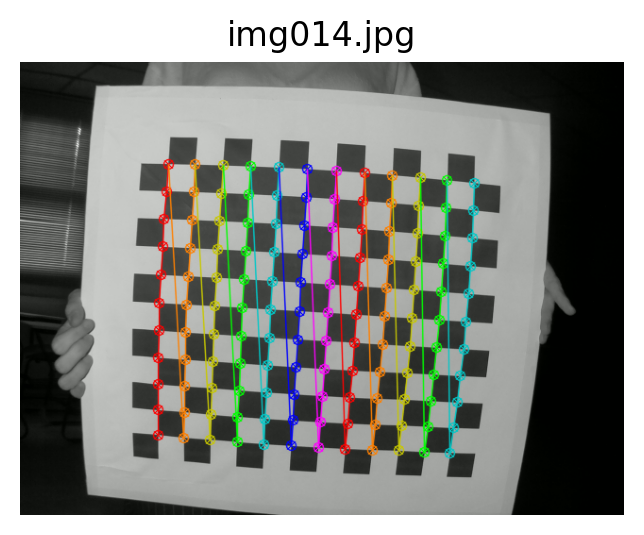

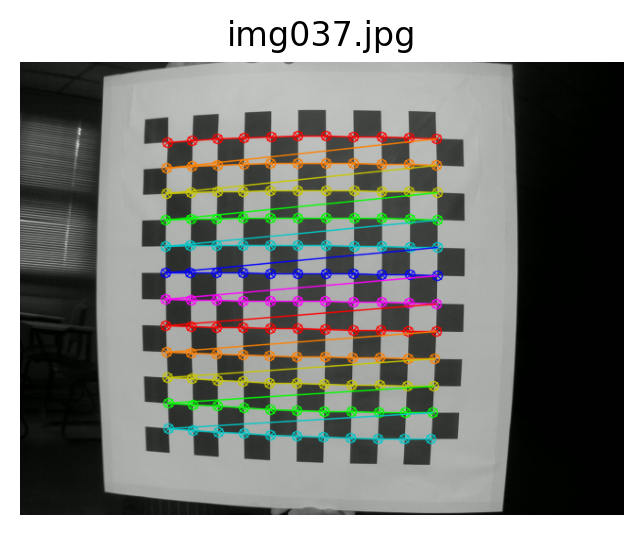

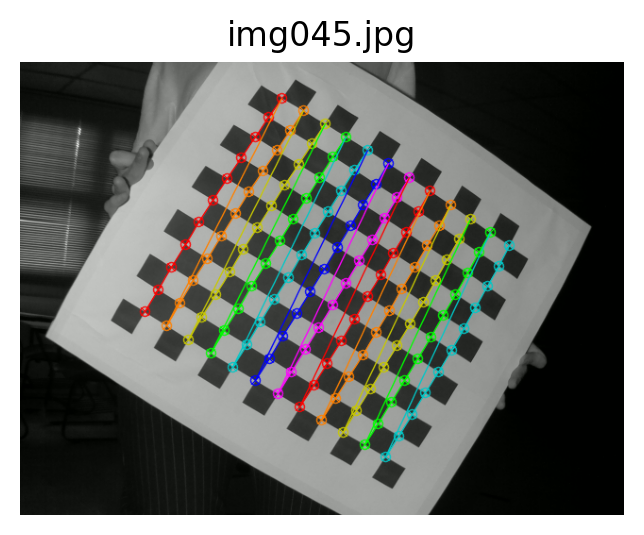

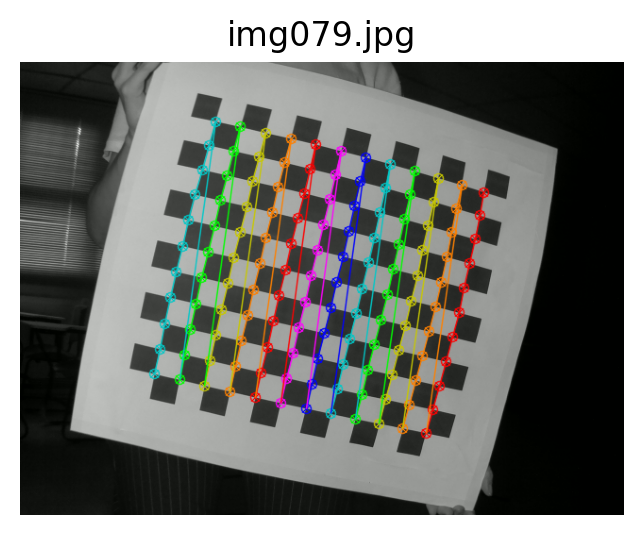

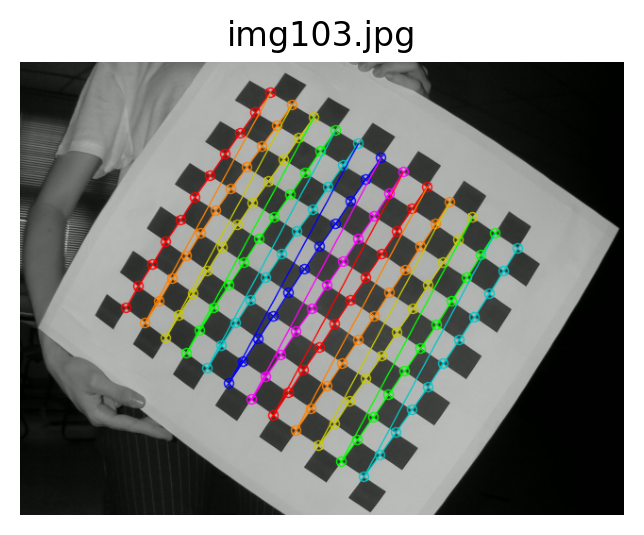

In [39]:
counter = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if ret == True:
        cornersRefined = cv2.cornerSubPix(gray, corners, (7,7), (-1,-1), criteria)
        imagePoints.append(cornersRefined)
        worldPoints.append(boardPoints)
        counter+=1
        cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
        plt.figure(figsize=(4, 3), dpi=200)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')
        plt.title(fname)
        cv2.imwrite(str(counter)+'Markers.png', img)

In [40]:
flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)
ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                            flags=flagsCalib,criteria=calibrateCriteria)
print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

Using 5 of 5 images
RMS re-projection error: 0.3701882189625183
Camera Matrix:
 [[681.93757496   0.         298.22457633]
 [  0.         681.32614362 270.33116533]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[ -0.22680026]
 [  2.85301937]
 [-29.3773594 ]
 [104.09043807]]


True

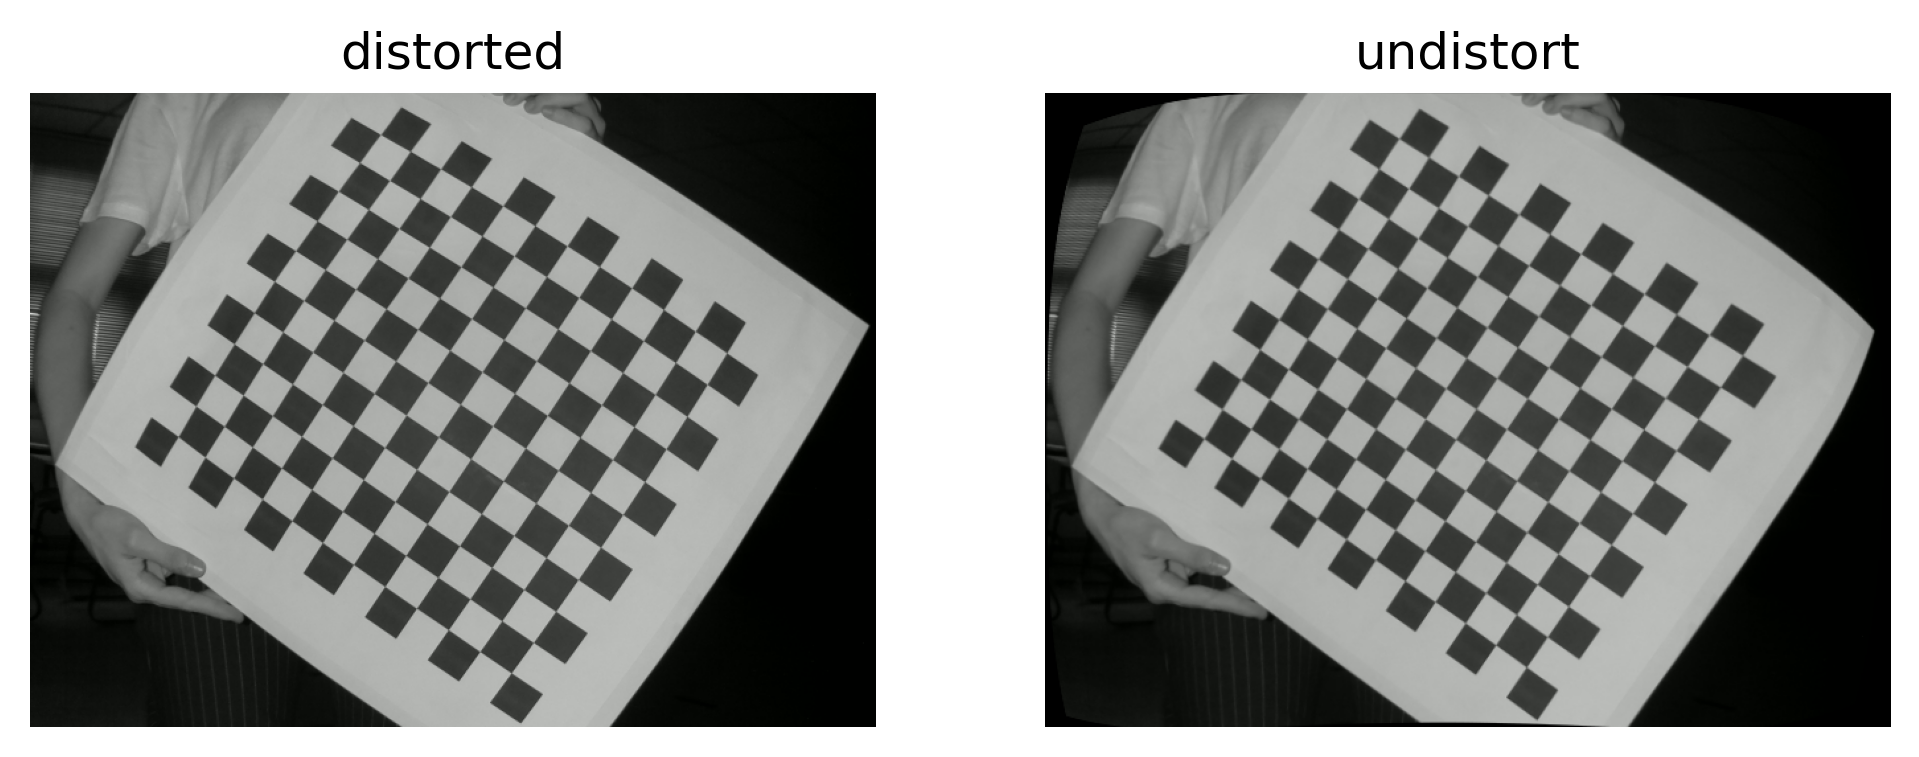

In [41]:
img = cv2.imread(images[-1])

fig, axs = plt.subplots(1,2,figsize=(8, 3), dpi=300)
axs[0].imshow(img[:,:,::-1])
axs[0].axis('off')
axs[0].set_title('distorted')

new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(cameraMatrix, k, imgSize, np.eye(3), balance=1)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix, k, np.eye(3), new_K, imgSize, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
axs[1].imshow(undistorted_img[:,:,::-1])
axs[1].axis('off')
axs[1].set_title('undistort')
cv2.imwrite('undistortOpenCV.png', undistorted_img)

if useDeng:
    k[0] = 0.2377
    k[1] = -0.3752
    k[2] = 6.6712
    k[3] = -27.4156
else:
    k[0] = 0
    k[1] = -0.6545
    k[2] = 4.5992
    k[3] = -11.3265

new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(cameraMatrix, k, imgSize, np.eye(3), balance=1)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(cameraMatrix, k, np.eye(3), new_K, imgSize, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
cv2.imwrite('undistortMATLAB_f600.png', undistorted_img)